In [1]:
import numpy as np
import scipy as s
import matplotlib.pyplot as plt
import time

from scipy.integrate import odeint
from scipy import pi

In [2]:
# physical parameters
a = 0.01   # radius (m)
mu = 4*pi*1e-7   # magnetic permeability
m = 1   # dipole moment (A/m^2)
R = 0.0001   # resistance (Ohm)
M = 0.01   # mass of magnet (kg)
g = 9.81   # gravity acceleration (N/kg)

# simulation parameters
init_height,init_speed = 0.1,0
t_max = 0.2
max_iter = 10000
dt = t_max/max_iter
T = np.linspace(0,t_max,max_iter)



def magForce(z,J):
    return 3*mu*J*m*a**2 /2 * z/(a**2+z**2)**(5/2)

def dPhidz(z,v):
    return -3*mu*m*v*a**2 /2 * z/(a**2+z**2)**(5/2)

dPhidz(2*a, -1)

0.0006743822141799098

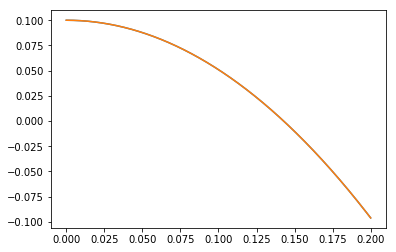

-0.0962
simulation took 0.002789020538330078 s


In [3]:
# solve using odeint function



# system of ODEs is z''=-g + F(J)/m, J = G(z') -> z''-F(G(z'))/m + g = 0 -> z''-alpha* z^2 z'/(a^2+z^2)^5 + g = 0
alpha = 1/R*(3*mu*m*(a**2)/2)**2
# initial conditions
ICs = init_height,init_speed

def derivatives(z,T):
        z0, z1 = z
        dz0dt = z1
        dz1dt = -alpha*(z0**2)*z1 / (a**2 + z0**2) - g
        return dz0dt, dz1dt

sim_start = time.time()
soln = odeint(derivatives, ICs, T)
sim_end = time.time()
path = soln[:,0]

plt.plot(T,path)
plt.plot(T,init_height-1/2*g*T**2)
plt.show()
    

print(path[-1])
print("simulation took",sim_end-sim_start,"s")

In [4]:
# solve using a basic finite difference approach "x[t+dt] = x[t] + dt*x'[t]"


Z = np.zeros((max_iter))
V = np.zeros((max_iter))
A = np.zeros((max_iter))
J = np.zeros((max_iter))

J[0] = 0
Z[0] = init_height
V[0] = 0
Z[1] = Z[0] + V[0]*dt

sim_start = time.time()
for i in range(0,max_iter-2):
    A[i] = -g + 1/M * magForce(Z[i],J[i])
    V[i+1] = V[i] + A[i]*dt
    J[i+1] = 1/R * dPhidz(Z[i+1],V[i+1])
    Z[i+2] = Z[i+1] + V[i+1]*dt
sim_end = time.time()  

#plt.plot(T,Z,'b')
#plt.plot(T,init_height-1/2*g*T**2,'r')
#plt.show()

#plt.plot(T,J,'k')
#plt.show()

print("final coordinate of magnet, in cm:",Z[-1]*100)
print("value from ref. simulation, in cm:",-7.16856)
print("and in case of free fall, in cm:  ",(init_height-1/2*g*T[-1]**2)*100)
print()
print("percentage error from reference:  ",(Z[-1]*100+7.16856)/(-7.16856)*100,"%")
print()
print("simulation took",sim_end-sim_start,"s")

final coordinate of magnet, in cm: -7.16498401135
value from ref. simulation, in cm: -7.16856
and in case of free fall, in cm:   -9.62

percentage error from reference:   -0.0498843372662 %

simulation took 0.15682005882263184 s


In [72]:
# solve using an improved finite difference approach "x[t+dt] = x[t] + dt*x'[t+1/2*dt]"


Z = np.zeros((max_iter))
V = np.zeros((max_iter))
A = np.zeros((max_iter))
J = np.zeros((max_iter))

J[0] = 0
Z[0] = init_height
A[0] = -g
V[0] = 0 + 1/2*dt*A[0] # V[0] is in fact V[1/2], all indices for velocity are shifted forwards by 1/2
Z[1] = Z[0] + V[0]*dt
J[1] = 1/R * dPhidz(Z[1],V[0]+1/2*dt*A[0])  # use extrapolated velocity between V[1/2] and V[3/2] to get V[1]

sim_start = time.time()
for i in range(1,max_iter-1):
    A[i] = -g + 1/M * magForce(Z[i],J[i])
    V[i] = V[i-1] + A[i]*dt  # e.g. for i=1: V[3/2] = V[1/2] + A[1]*dt
    Z[i+1] = Z[i] + V[i]*dt # e.g. for i=1: Z[2] = Z[1] + V[3/2]*dt
    J[i+1] = 1/R * dPhidz(Z[i+1],V[i]+1/2*dt*A[i])  # e.g. for i=1: J[2] = f( Z[2], V[3/2]+A[2]*1/2*dt )
sim_end = time.time()   
    
#plt.plot(T,Z,'b')
#plt.plot(T,init_height-1/2*g*T**2,'r')
#plt.show()

#plt.plot(T,J,'k')
#plt.show()

print("final coordinate of magnet, in cm:",Z[-1]*100)
print("value from ref. simulation, in cm:",-7.16856)
print("and in case of free fall, in cm:  ",(init_height-1/2*g*T[-1]**2)*100)
print()
print("percentage error from reference:  ",(Z[-1]*100+7.16856)/(-7.16856)*100,"%")
print()
print("simulation took",sim_end-sim_start,"s")

final coordinate of magnet, in cm: -7.16550381509
value from ref. simulation, in cm: -7.16856
and in case of free fall, in cm:   -9.62

percentage error from reference:   -0.0426331774935 %

simulation took 0.09778380393981934 s


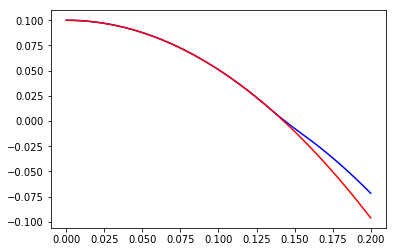

final coordinate of magnet, in cm: -7.16550382307
value from ref. simulation, in cm: -7.16856
and in case of free fall, in cm:   -9.62

percentage error from reference:   -0.0426330661675 %

simulation took 0.08935666084289551 s


In [5]:
# solve using finite difference approach which does not invoke matrices A,V, but instead expresses time derivatives from Z
# use two point operator for A=Z'':  (Z[i+1] - 2*Z[i] + Z[i-1]) / dt**2 = g - 1/M * magForce(Z[i],J[i])
# use central difference for V=Z': (Z[i+1] - Z[i-1])  / (2*dt) == Z'

T = np.linspace(0,t_max,max_iter)

Z = np.zeros((max_iter))   # array that stores positions of magnet as time progresses
J = np.zeros((max_iter))   # redundant in this implementation

const = -1/R * 1/M * (3/2 * mu * m * a**2)**2

Z[0] = init_height
Z[1] = Z[0] - 1/2 * g * dt**2
J[0] = 0
J[1] = 1/R * dPhidz(Z[1], (Z[1]-Z[0])/dt)

sim_start = time.time()
for i in range(1,max_iter-1):

    # one approach as follows - but not feasible this way, as J[i] needs Z[i+1] and vice versa
    #J[i,:] = 1/R * dPhidz(Z[i]-Z_ring, (Z[i+1]-Z[i-1])/(2*dt))
    #F[i,:] = magForce(Z[i]-Z_ring, J[i,:])
    #Z[i+1] = dt**2 * (-g + 1/M * F[i,:]) + 2*Z[i] - Z[i-1]
    
    
    # better to directly express J[i] = beta * (Z[i+1]-Z[i-1])/(2*dt) * Z[i]
    Z[i+1] = (2*Z[i] - Z[i-1] - g*dt**2 - const / 2 * Z[i-1] * Z[i]**2 * dt / (a**2 + Z[i]**2)**5 )  /  (1 - const / 2 * Z[i]**2 * dt / (a**2 + Z[i]**2)**5)
sim_end = time.time()
    
plt.plot(T,Z,'b')
plt.plot(T,init_height-1/2*g*T**2,'r')
plt.show()



print("final coordinate of magnet, in cm:",Z[-1]*100)
print("value from ref. simulation, in cm:",-7.16856)
print("and in case of free fall, in cm:  ",(init_height-1/2*g*T[-1]**2)*100)
print()
print("percentage error from reference:  ",(Z[-1]*100+7.16856)/(-7.16856)*100,"%")
print()
print("simulation took",sim_end-sim_start,"s")

In [13]:
import numpy as np
import scipy as sp
import scipy.special

x = np.ones(10)
print(sp.special.ellipk(x-0.5))

y = np.array([[1,2,3],[4,5,6]])
print(y[0,:])


def emf_tube(J,i):
    return J[i]-J[i-1]
emf_tube = np.vectorize(emf_tube)

print(emf_tube(y,1))

[ 1.85407468  1.85407468  1.85407468  1.85407468  1.85407468  1.85407468
  1.85407468  1.85407468  1.85407468  1.85407468]
[1 2 3]


IndexError: invalid index to scalar variable.